<a name='0'></a>

# EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks

[EfficientNets](https://arxiv.org/abs/1905.11946) is a family of ConvNets that achieves better accuracy and efficiency than most previous ConvNets. EfficientNet-B7 achieved 84.3% accuracy on ImageNet while being `8.4x smaller` and `6.1 faster` than other previous ConvNets architectures.

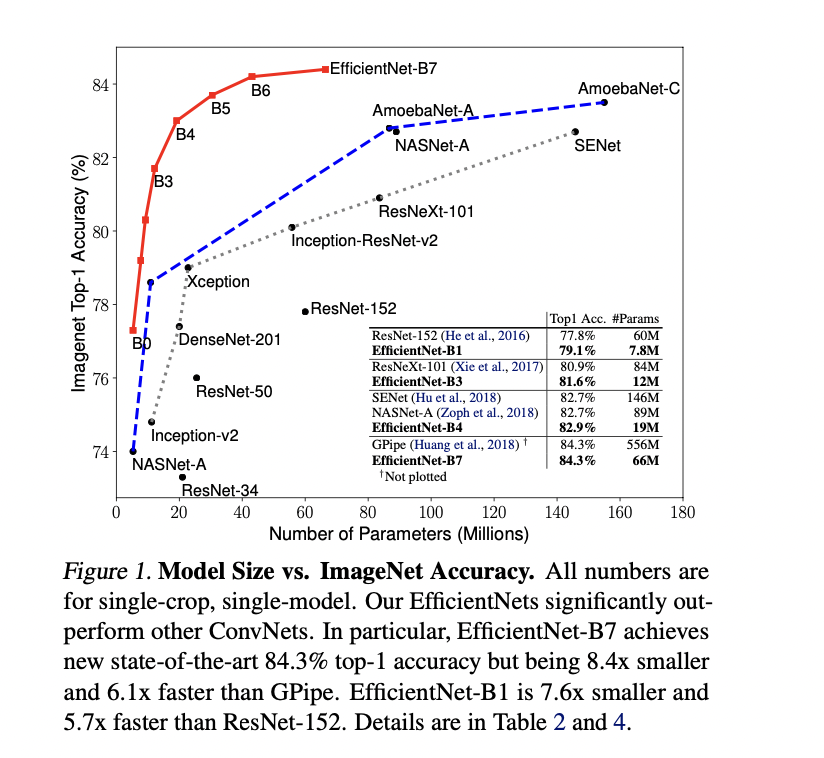

What's in here:

* [Introduction](#1)
* [Compound Model Scaling](#2)
* [EfficientNet Architecture](#3)
* [EfficientNet implementation](#4)
* [EfficientNet Final Notes](#5)
* [EfficientNetV2](#6)
* [Reference Implementations and Further Learning](#7)

<a name='1'></a>

## 1. Introduction

Scaling up ConvNets has been one of the major challenges in designing high performing and efficient ConvNets architectures. There are 3 ways in which networks can be scaled: image resolution, width(number of channels/layer) and depth(number of layers).

The central question that EfficientNet addresses is: ***Is there a principled method to scale up ConVnets that can achieve better accuracy and efficiency?*** More precisely, EfficientNet demonstrates that it is possible to effectively scale both width, depth and resolution and hence introducing a scaling method called `compound scaling method`. The depth, width, and the resolution of the image can be scaled by fixed scaling coefficients.

Compound scaling makes sense because if the input image is bigger, the network needs more layers(representing depth) to increase the receptive fields and more channels(representing width) to capture more representations.

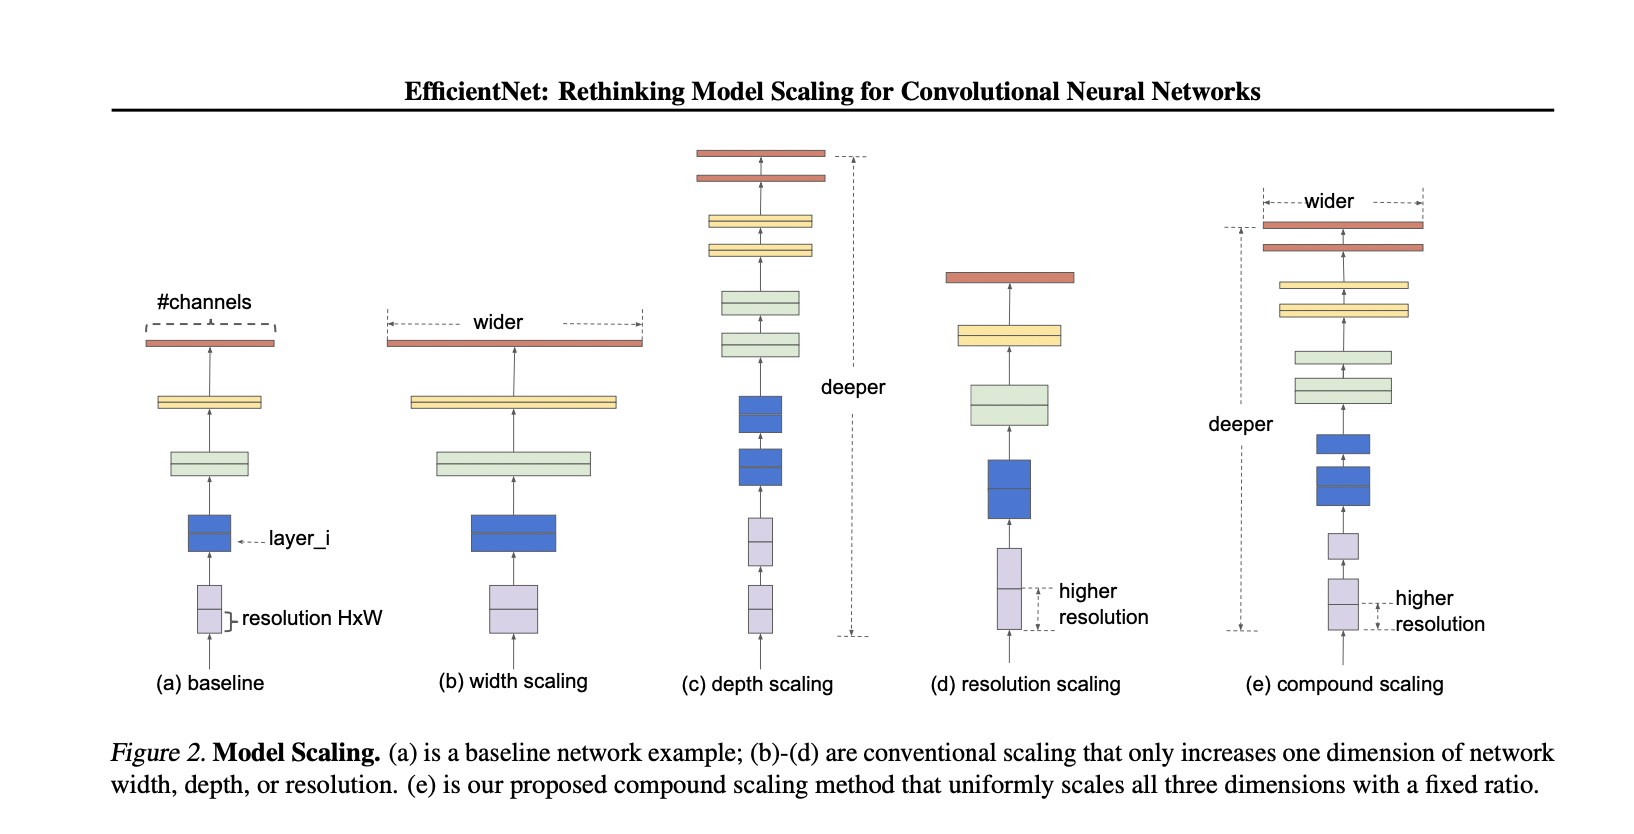

<a name='2'></a>

## 2.Compound Model Scaling

The principle idea behind EfficientNet is achieving better accuracy and efficiency by scaling the dimension of the network width, depth, and resolution. All layers are scaled uniformly with a constant ratio called `compound scaling coefficient `φ`.

**Scaling depth `d`** is the most common scaling method in ConvNets architectures design. Deer ConvNets are able to capture richer and complex features and have high generalization ability. Example of deeper ConvNets are Inception([v1](https://arxiv.org/abs/1409.4842), [v2 & v3](https://arxiv.org/abs/1512.00567), [v4](https://arxiv.org/abs/1602.07261)) and [ResNet](https://arxiv.org/abs/1512.03385). The downside of deeper networks is that they hard to train due to vanishing gradient problem although techniques like batch normalization and skip connections can help reduce the training problems. Very deep networks provides diminishing accuracy for higher depths.

**Scaling with `w`** is mostly used in small size models such as [MobileNet](https://arxiv.org/abs/1704.04861). Just like deeper networks, wider networks can capture richer representations but they are easier to train compared to deeper networks. There is also a trend here: wider but shallow networks can fail to capture high-level features from the image and the accuracy quickly saturates when networks become much wider.

**Scaling the resolution `r`** of input image can also helps the ConvNets to capture richer representations. ConvNets with higher resolutions such as [GPipe](https://arxiv.org/pdf/1811.06965.pdf) that used 480x480 achieved state of the art results on ImageNet. Higher resolutions such as 600x600 are also used in object detection. But similar to the behavior of large width and depth, extreme resolutions diminishes accuracy. Below image indeed shows how both bigger networks with large depth, width and resolutions achieve better accuracy but the accuracy starts diminishing after 80% showing the downside of scaling single dimension.

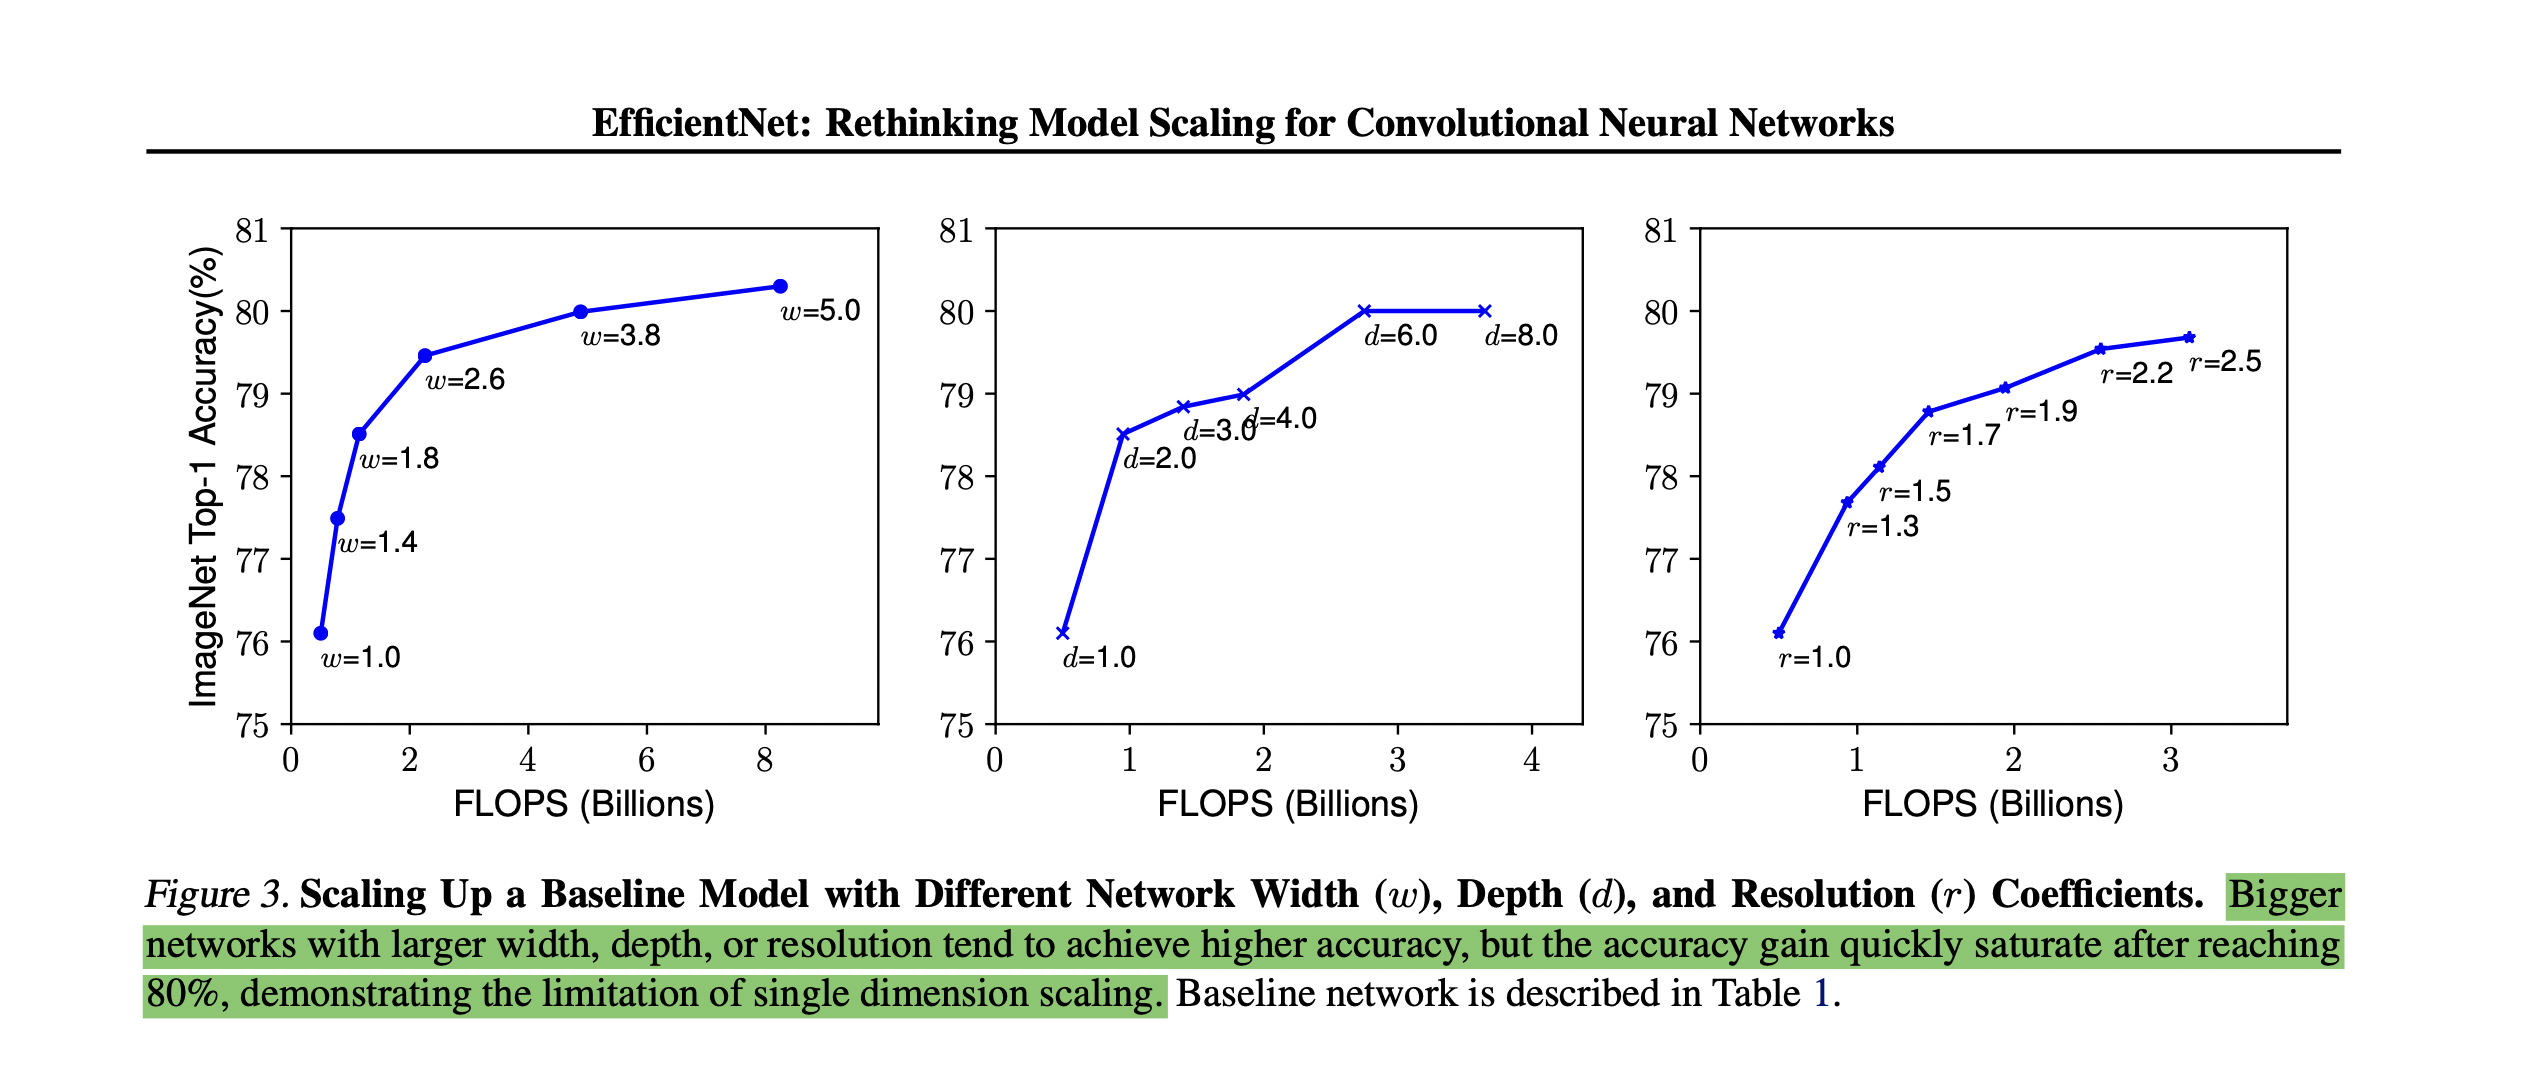

Scaling depth, width, and resolution undoubtely improves accuracy but the gain in accuracy starts decreasing for bigger models. This motivate the compound scaling!

### Compound Scaling

The dimensions of ConvNets architectures are not independent. If we have higher resolution images, we should increase depth of the network to capture similar features in bigger images. When the resolution is higher, we should also increase the network depth to capture the fine-grained patterns with more pixels in high resolution images. Such intuition clearly shows that depth, width and resolution depend on each other and we thus need to balance them.

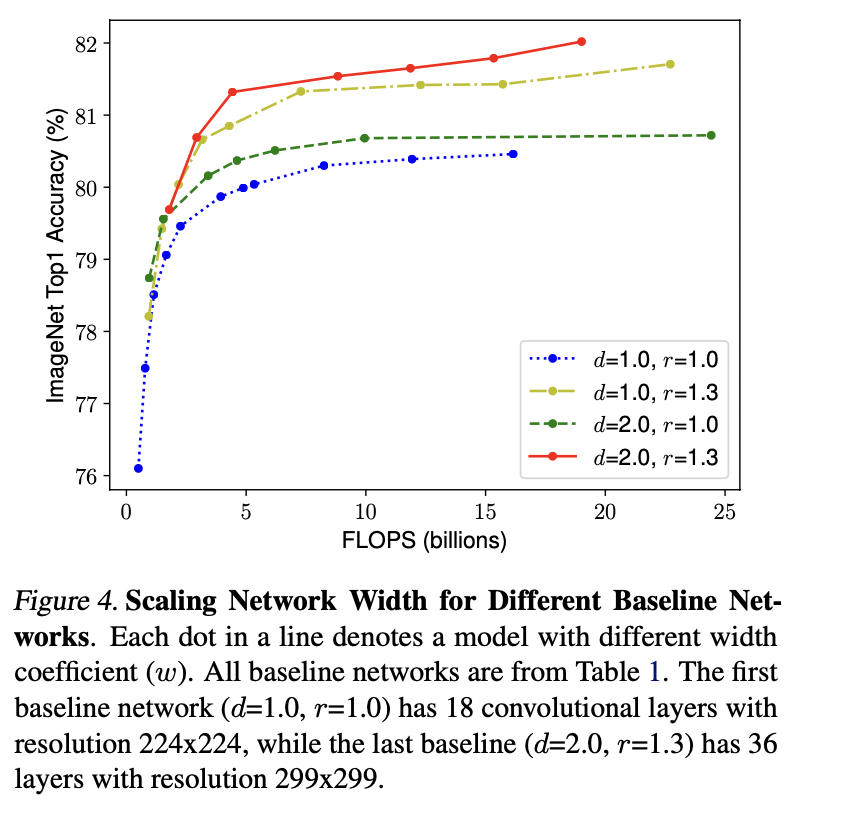

From the diagram above, it is clear that if we only scale width and don't scale depth and resolution(`blue dot line, d=1.0, r=1.0`), the accuracy saturates quickly. But if we scale both depth and resolution, we get better accuracy under the same FLOPs. ***As a conclusion, in order to design ConvNets that have better accuracy and efficiency, we must balance all dimensions of width, depth, and resolution during training.*** That's the meaning of compound scaling.


<a name='3'></a>

## 3. EfficientNet Arhitecture

The baseline of EfficientNet is almost similar to MobileNetv2 and MnasNet. Its main building block is mobile inverted bottleneck `MBConv` with squeeze and excitation optimization.

The inverted residual block was used in [MobileNetv2](https://arxiv.org/pdf/1801.04381v4.pdf) and [MnasNet](https://ai.googleblog.com/2018/08/mnasnet-towards-automating-design-of.html). The squeeze and excitation block were borrowed from [SENet](https://arxiv.org/pdf/1709.01507v4.pdf).

Below is the main architecture of baseline of EfficientNet entilted `EfficientNet-B0`. Other versions of EfficientNet-B1 to EfficientNet-B7 are obtained by using different `compound scaling coefficient φ`.

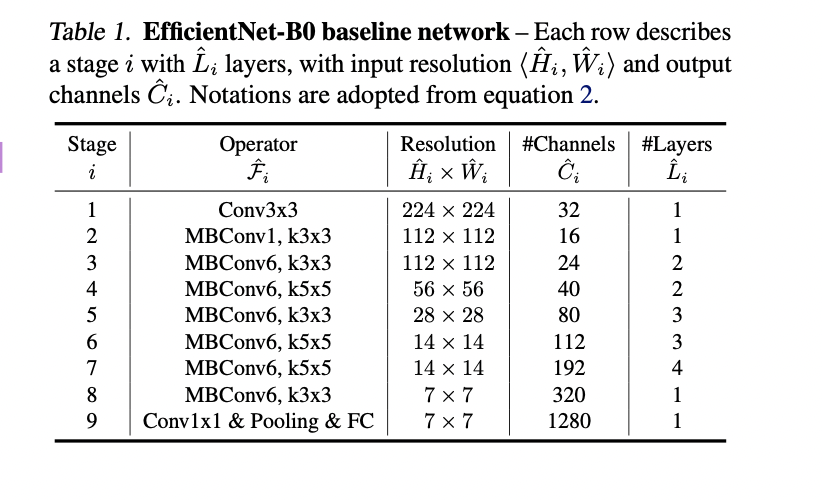

### MBConv - Mobile Inverted Bottleneck

`MBConv` or mobile inverted bottleneck is the main building block of EfficientNet.

The EfficientNet MBConv block is a combination of MobileNetV3 inverted bottleneck block and squeeze and excitation block(SE) from SENet.

Below image depicts the MBConv block.



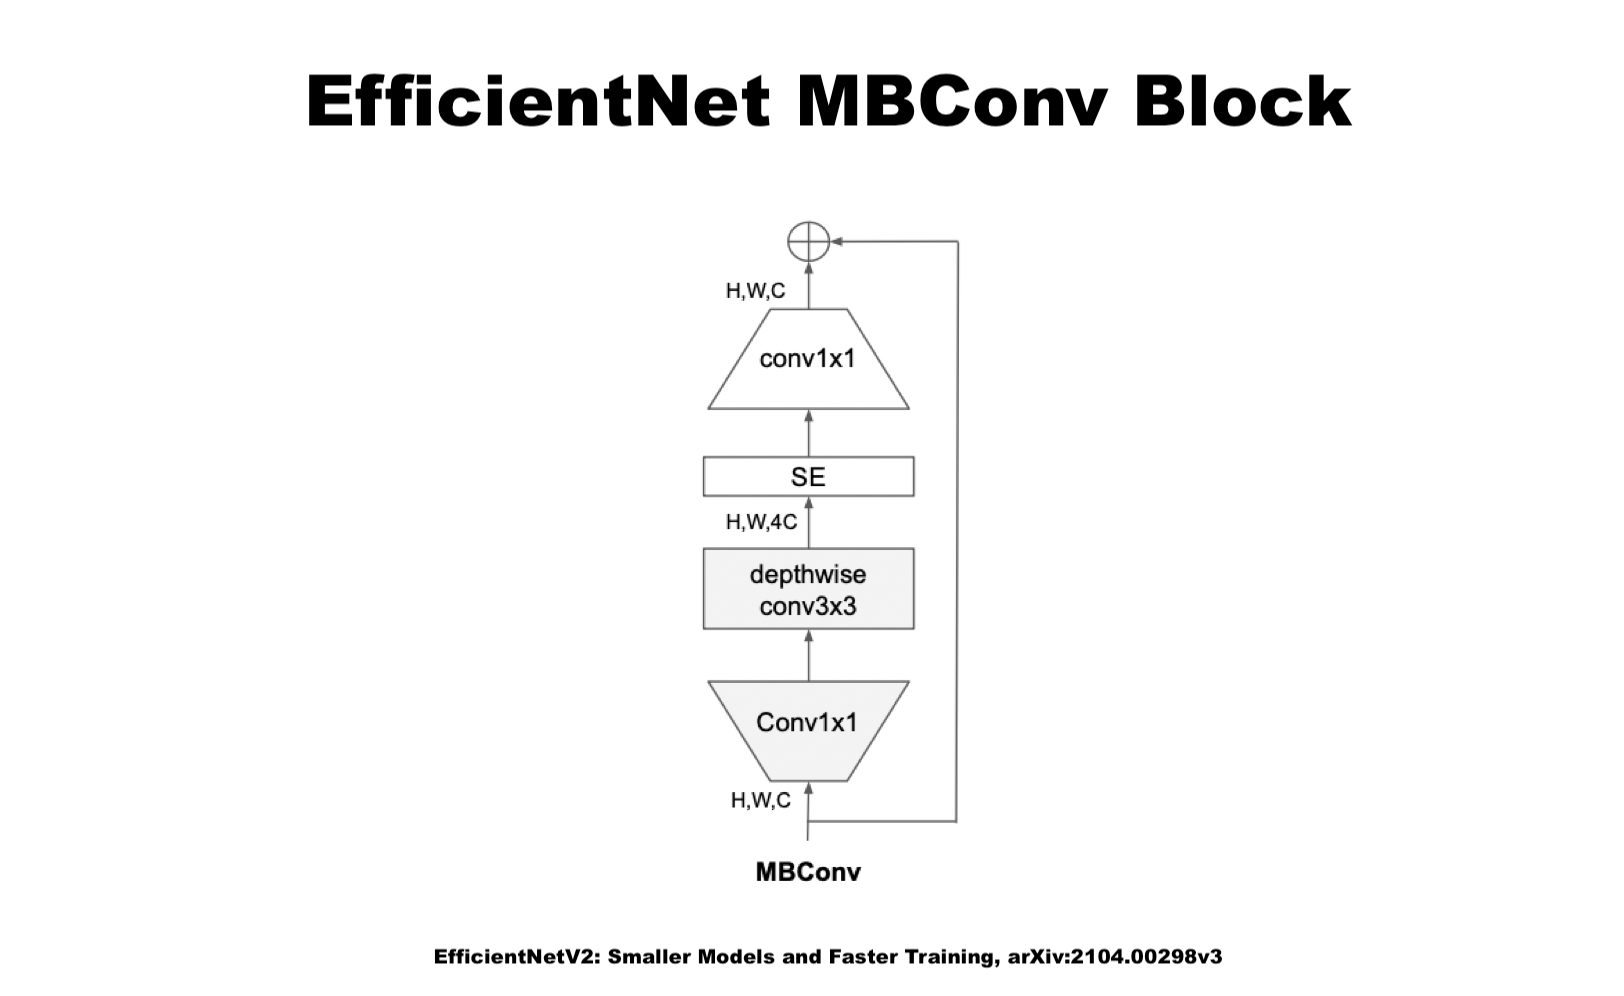

<a name='4'></a>

## 4. EfficientNet Implementation

### Set Up

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import math

Let's build the architecture of EfficientNet-B0. For simplicity, we will start with MBConv block. 

### Building MBConv Block

In [62]:
def mbconv_block(input, filters_in, filters_out, kernel_size=3, strides=1, exp_ratio=6, se_ratio=0.25):
  """
  Arguments:
  -------
  input: input tensor
  filters_in: input filters
  filters_out: output filters
  kernel_size: the size/dimension of convolution filters
  strides: integer, the stride of convolution. If strides=2, padding in depthwise conv is 'valid'.
  exp_ratio: expansion ration, an integer for scaling the input filters/filters_in
  se_ratio: a float between 0 and 1 for squeezing the input filters
  -------
  """

  # Expansion layer: exp_ratio is integer >=1

  filters = filters_in * exp_ratio
  if exp_ratio != 1:
    x = layers.Conv2D(filters, kernel_size=1, padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = keras.activations.swish(x)

  else:
    x = input

  # Depthwise convolution
  x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = keras.activations.swish(x)

  # Squeeze and excitation
  if se_ratio > 0 and se_ratio <= 1:
    filters_se = max(1, int(filters_in * se_ratio)) #max with 1 to make sure filters are not less than 1
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Conv2D(filters_se, kernel_size=1, padding='same', activation='swish')(se)
    se = layers.Conv2D(filters, kernel_size=1, padding='same', activation='sigmoid')(se)
    x = layers.multiply([x, se])

  x = layers.Conv2D(filters_out, kernel_size=1, padding='same')(x)
  x = layers.BatchNormalization()(x)

  # Add identity shortcut if strides=2 and in & filters are same
  if strides == 1 and filters_in == filters_out:
    x = layers.add([x, input])

  return x

### Other Utility Functions

The principal contribution of EfficientNet is mostly based on the idea of compound scaling - scaling the input resolution, the width of the network, and the depth. Let's define functions for scaling the width and the depth.

***Note: We will implement the baseline EfficientNet `EfficientNet-B0`. EfficientNet-B0 uses the unscaled width, resolution, and width. The `width_coefficient=1`, `depth_coefficient=1` and `input_resolution=224`. If you want to implement other versions of EfficientNets, you can use the following utility functions (`scale_number_of_blocks`,  `scale_width`) and get their appropriate parameters from the [paper](https://arxiv.org/abs/1905.11946) or this [reference implementation](https://github.com/keras-team/keras-applications/blob/master/keras_applications/efficientnet.py). Scaling the resolution is pretty simple, we only have to change the shape of the input image.***

In [43]:
def scale_number_of_blocks(block_repeats, depth_coefficient=1):
  """Scale and round the number of block repeatitions(scale depth in other words)"""

  scaled_blocks = int(math.ceil(block_repeats * depth_coefficient))
  
  return scaled_blocks

In [44]:
def scale_width(filters, width_coefficient=1, depth_divisor=8):

  filters *= width_coefficient
  new_filters = (filters + depth_divisor / 2) // depth_divisor * depth_divisor
  new_filters = max(depth_divisor, new_filters)

  # make sure that scaled filters down does not go down by more than 10%
  if new_filters < 0.9 * filters:
    new_filters += depth_divisor

  return int(new_filters)

There are up to 8 versions of EfficientNets models. In our case, we will implement `EfficientNet-B0` which is the baseline network. But the process for implementing other versions remain the same. It's essentially changing depth, width, and increasing input resolution.

### Building the Rest of the Model

For building EfficientNet-B0, we just have to start with the stem of the network, stack the MBConv blocks appropriately and add the classification head. The first block of every MBConv stage has a stride of 1 and other blocks have strides `strides`.

In [67]:
# Setting some hyperparameters for EfficientNet-B0

input_shape = (224, 224, 3)

# If using the scaling utility functions, use the following hyperparamaters for EfficientNet-B0
# depth_coefficient = 1.0
# width_coefficient = 1.0
# depth_divisor = 8

# The stem of network
input = layers.Input(input_shape)
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = layers.BatchNormalization()(x)
x = keras.activations.swish(x)

# MBConv blocks
# Block 1: input filters=32, output filters=16, kernel size=3, block repeats=1
x = mbconv_block(x, filters_in=32, filters_out=16, kernel_size=3, strides=1, exp_ratio=1)

# Block 2: input filters=16, output filters=24, kernel size=3, strides=2, block repeats=2
# the first block of every stage has stride of 1
x = mbconv_block(x, filters_in=16, filters_out=24, kernel_size=3, strides=1, exp_ratio=6)
x = mbconv_block(x, filters_in=16, filters_out=24, kernel_size=3, strides=2, exp_ratio=6)

# Block 3: input filters=24, output filters=40, kernel size=5, strides=2, block repeats=2 
x = mbconv_block(x, filters_in=24, filters_out=40, kernel_size=5, strides=1, exp_ratio=6)
x = mbconv_block(x, filters_in=24, filters_out=40, kernel_size=5, strides=2, exp_ratio=6)

# Block 4: input filters=40, output filters=80, kernel size=3, strides=2, block repeats=3
x = mbconv_block(x, filters_in=40, filters_out=80, kernel_size=3, strides=1, exp_ratio=6)
x = mbconv_block(x, filters_in=40, filters_out=80, kernel_size=3, strides=2, exp_ratio=6)
x = mbconv_block(x, filters_in=40, filters_out=80, kernel_size=3, strides=2, exp_ratio=6)
x = mbconv_block(x, filters_in=40, filters_out=80, kernel_size=3, strides=2, exp_ratio=6)

# Block 5: input filters=80, output filters=112, kernel size=5, strides=1, block repeats=3
x = mbconv_block(x, filters_in=80, filters_out=112, kernel_size=5, strides=1, exp_ratio=6)
x = mbconv_block(x, filters_in=80, filters_out=112, kernel_size=5, strides=1, exp_ratio=6)
x = mbconv_block(x, filters_in=80, filters_out=112, kernel_size=5, strides=1, exp_ratio=6)

# Block 6: input filters=112, output filters=192, kernel size=5, strides=2, block repeats=4
x = mbconv_block(x, filters_in=112, filters_out=192, kernel_size=5, strides=1, exp_ratio=6)
x = mbconv_block(x, filters_in=112, filters_out=192, kernel_size=5, strides=2, exp_ratio=6)
x = mbconv_block(x, filters_in=112, filters_out=192, kernel_size=5, strides=2, exp_ratio=6)
x = mbconv_block(x, filters_in=112, filters_out=192, kernel_size=5, strides=2, exp_ratio=6)

# Block 7: input filters=192, output filters=320, kernel size=3, strides = 1, block repeats=1
x = mbconv_block(x, filters_in=192, filters_out=320, kernel_size=3, strides=1, exp_ratio=6)

# Classification head
x = layers.Conv2D(filters=1280, kernel_size=1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = keras.activations.swish(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(units=1000, activation='softmax')(x)

efficientnet_b0 = keras.Model(inputs=input, outputs=output)

In [64]:
efficientnet_b0.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1346 (Conv2D)           (None, 112, 112, 32  896         ['input_31[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_1022 (Batc  (None, 112, 112, 32  128        ['conv2d_1346[0][0]']            
 hNormalization)                )                                                          

We can also plot the EfficientNet-B0 network with Keras plotting utils.

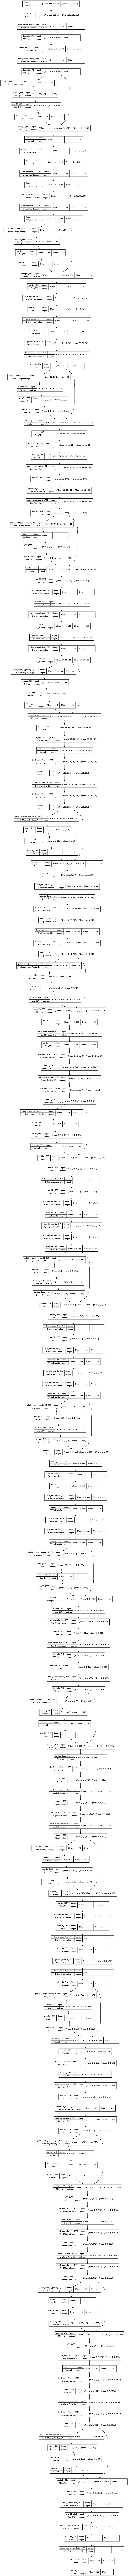

In [65]:
plot_model(efficientnet_b0, show_shapes=True)

The following code loads the built-in EfficientNet-B0 from [Keras applications](https://keras.io/api/applications/). 

In [61]:
eff_b0 = keras.applications.EfficientNetB0(include_top=True, input_shape=(224, 224, 3))
eff_b0.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_30[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

<a name='5'></a>

## 5. EfficientNetV1 Final Notes

The principal idea behind EfficientNet is compound scaling method. Scaling the width, depth and resolution can leads to more efficient models with improved accuracy.

The following table give a fair comparison of EfficientNets models and other ConvNets.

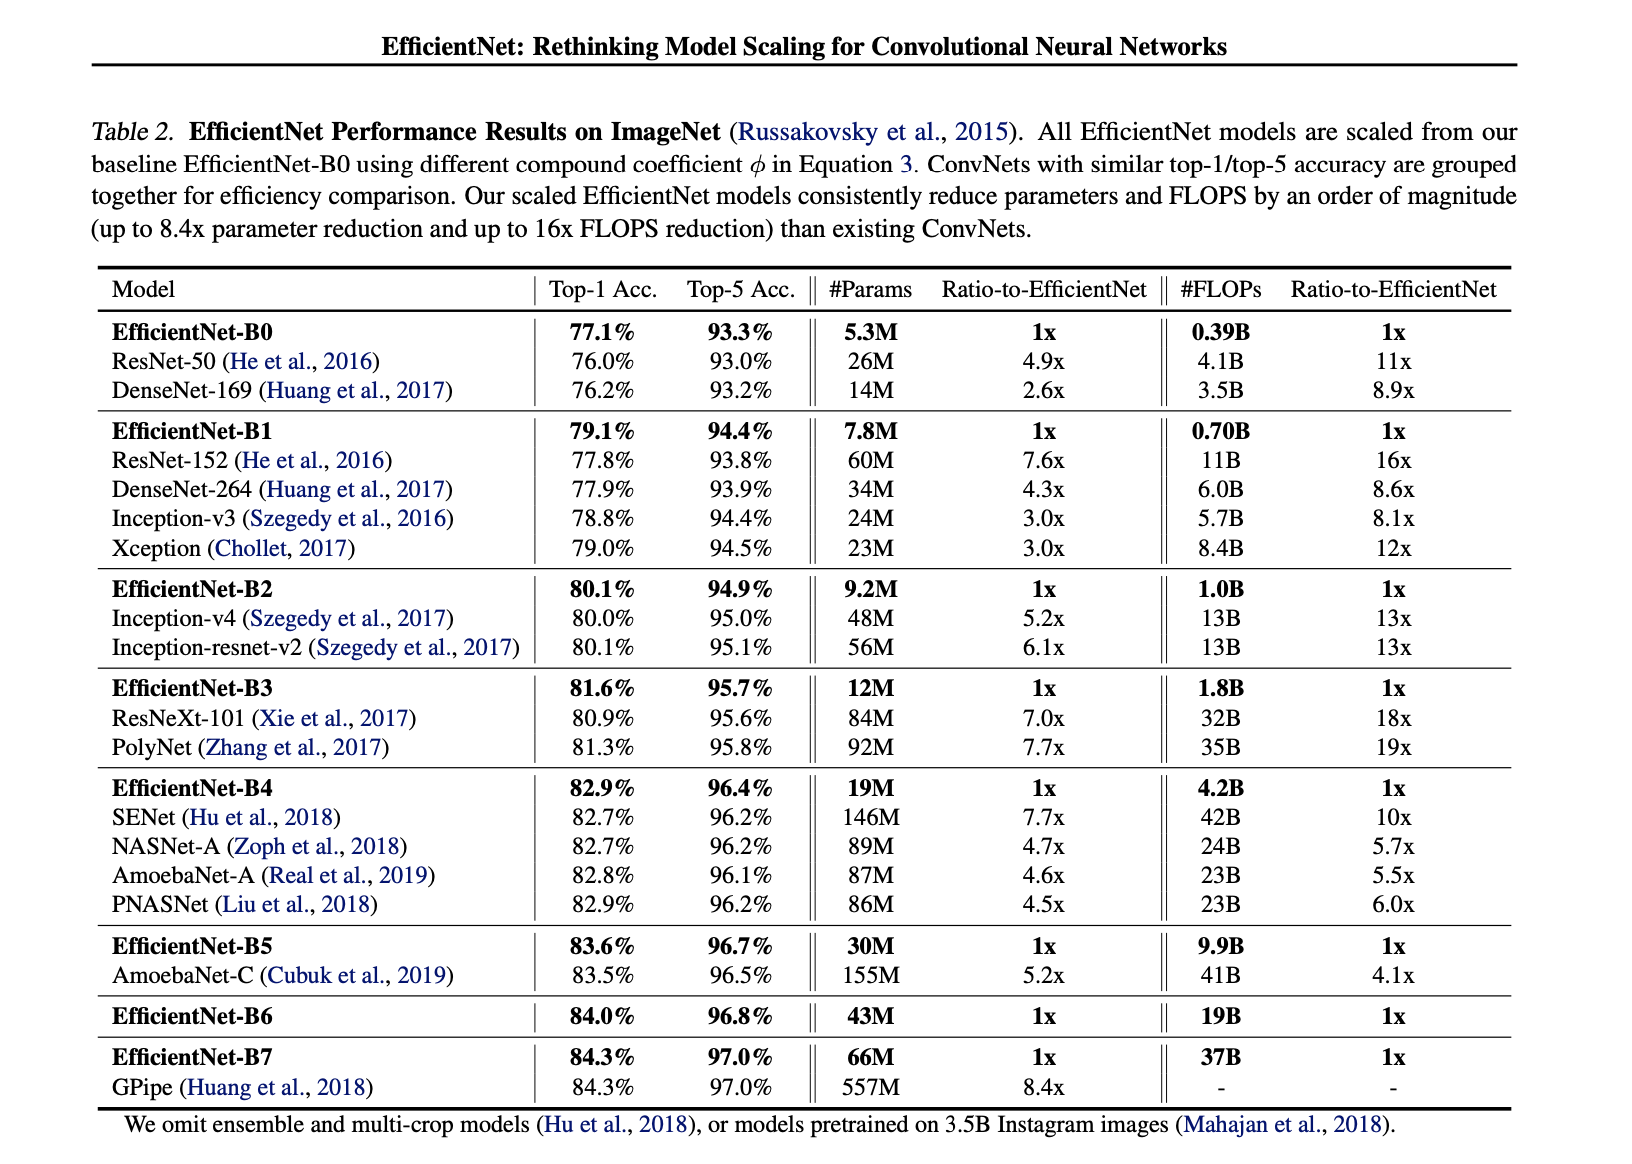

Also, the figure below shows the positive effects of compund scaling on accuracy compared to individual scaling of width, depth or resolution. 

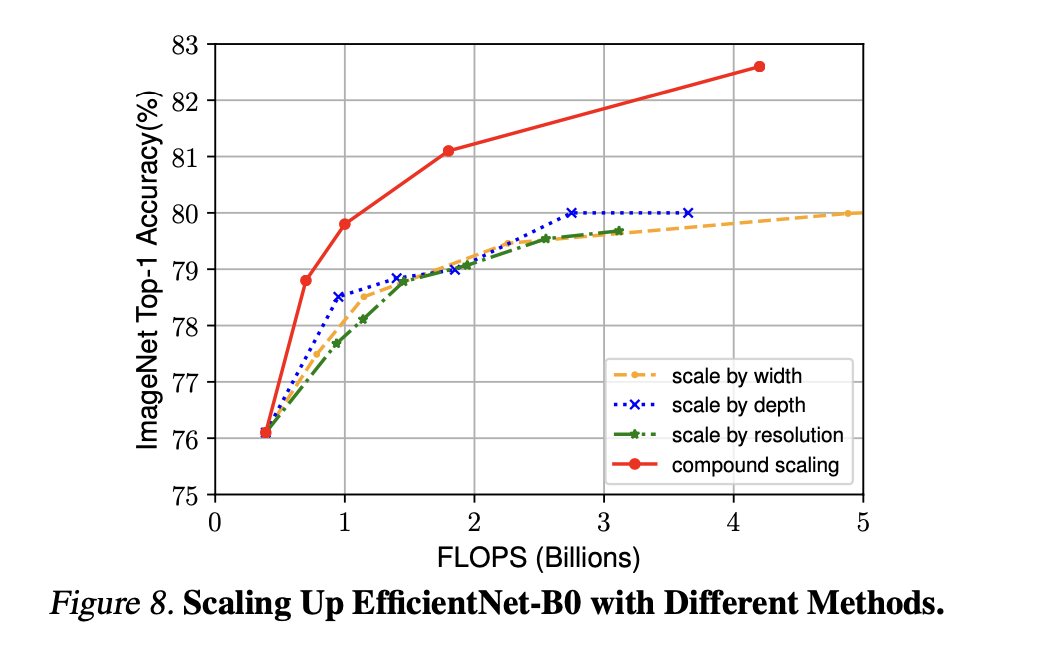

<a name='6'></a>

## 6. EfficientNetV2

[EfficientNetV2](https://arxiv.org/abs/2104.00298v3) is a new and improved ConvNets that have faster training speed and better parameter efficiency than all most ConvNets.

Just like EfficientNetV1, EfficientNetV2 is also based on Neural Architecture Search(NAS), a technique used for automating the design of neural networks. In EfficientNetv2, NAS is merely used for optimizing the training and parameter efficiency.

Also, unlike EfficientNet1 that uses uniform scaling of depth, width and resolution(compound scaling), EfficientNetV2 uses non-uniform scaling method. 

EfficientNetV2 uses MBConv bock and Fused-MBConv block. Fused-MBConv replaces the depthwise convolution with normal 3x3 convolution in the MBConv (Mobile inverted bottleneck). Deptwise convolutions have fewer parameters and FLOPs than normal convolutions but they are not hard to train on modern accelerators. Check this discussion on the downside of dephwise convolutions (or grouped convolution in general). surprisingly, the authors found the best way to mix MBConv and Fused-MBConv blocks. Below figure illustrates those two blocks.

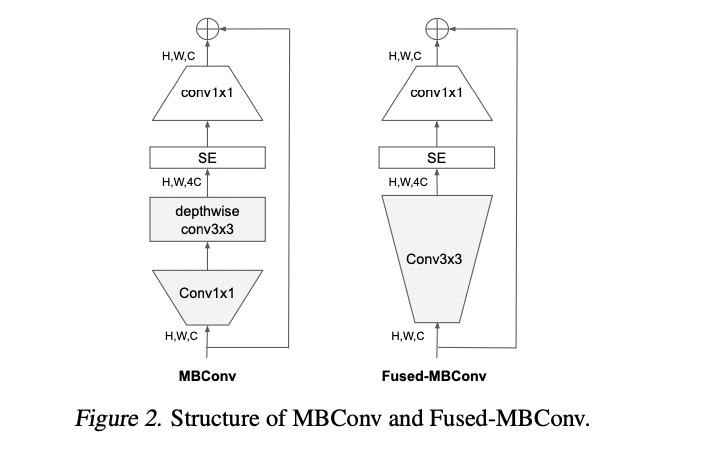

Finally, EfficientNetV2 is built around progressive learning. That means that early in training process, the network is trained with smaller images and weak regularization to capture better representations easily and fast, but then along the training process, the image size is increased gradually and strong regularizations are added to ease the learning. More precisely, the paper uses the following regularization techniques:

* [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) for randomly dropping units and channels during training. Dropout is one of the strong regularization techniques used to avoid overfitting.

* [Randaugment](https://arxiv.org/abs/1909.13719v2) which is an automated data augmentation technique.

* [Mixup](https://paperswithcode.com/method/mixup), a data augmentation technique that generates a weighted combinations of random image pairs from the training data.

<a name='7'></a>

## 7. References Implementations and Further Learning

* [Keras Applications - EfficientNets](https://github.com/keras-team/keras-applications/blob/master/keras_applications/efficientnet.py)
* [EfficientNetV1 Official Implementation](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet)
* [EfficientNetV1 paper](https://arxiv.org/abs/1905.11946)
* [EfficientNetV2 paper](https://arxiv.org/pdf/2104.00298v3.pdf)
* [EfficientNetv2 Official Implementation](https://github.com/google/automl/tree/master/efficientnetv2)

### [BACK TO TOP](#0)